In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import os
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler

##### Import Dataset

In [30]:
df_original = pd.read_csv('output\dataset_worldbank_transposed.csv')
df_original.head()

,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population),"Prevalence of underweight, weight for age (% of children under 5)","Community health workers (per 1,000 people)",...,Forest area (% of land area),Forest area (sq. km),Land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (% of total land area),Urban land area where elevation is below 5 meters (sq. km),Rural land area where elevation is below 5 meters (% of total land area),Rural land area where elevation is below 5 meters (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aruba,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
2,Aruba,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
3,Aruba,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0
4,Aruba,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0


##### Drop Missing Values > 50%

In [31]:
# function to visualize the proportion of missing value
def visual_nan(df, name="", isSorted=False, savePlot=True):
    
    sort = ''
    if isSorted:
        df=df[df.isna().sum().sort_values().keys()]
        sort = '_sorted'
    missing_value = df.isna().melt(value_name="missing")

    ax = sns.displot(data=missing_value,
                      y="variable",
                      hue="missing",
                      multiple="fill",
                      height=10,
                      aspect=1.5)
    plt.xlabel("Proportion of missing value")
    plt.title(f"Missing values of {name}")
    
    if savePlot:
        filename = name.split('.')
        plt.savefig(f"plot/{filename[0]}{sort}.png")

    return ax

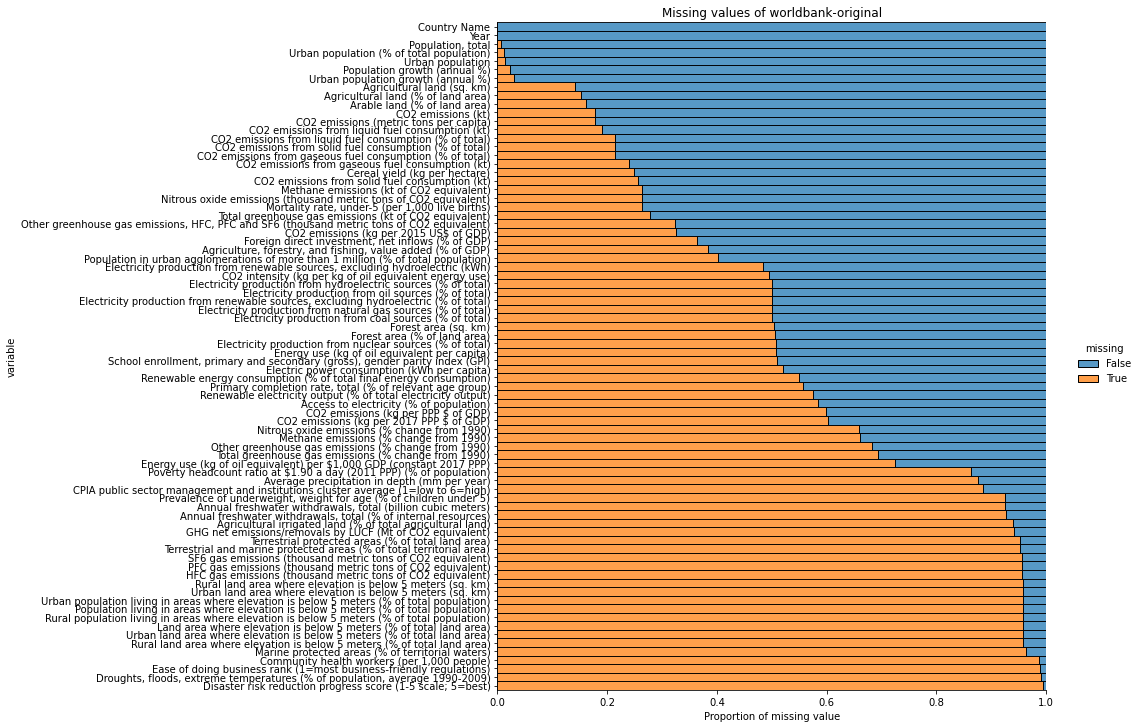

In [32]:
visual_nan(df_original, 'worldbank-original', isSorted=True)

In [33]:
# function to display the number of missing values and missing ratio
def missing_ratio_summary(df):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)

    display(missing.sort_values(by=['ratio']))
    
# function to return a list of columns with more than x% of missing values 
def get_X_missing(df, X):
    missing = pd.DataFrame(df.isna().sum(), columns=['missing'])
    missing.reset_index(inplace=True)
    missing.rename(columns={'index':'col'}, inplace=True)
    missing['ratio'] = (missing['missing']/len(df)*100).round(2)
    
    missing_list = missing[missing['ratio'] > X]['col'].tolist()
    return missing_list
    
missing_ratio_summary(df_original)

,col,missing,ratio
0,Country Name,0,0.00
1,Year,0,0.00
5,"Population, total",103,0.63
2,Urban population (% of total population),192,1.18
3,Urban population,225,1.39
...,...,...,...
17,Marine protected areas (% of territorial waters),15616,96.24
9,"Community health workers (per 1,000 people)",16013,98.69
15,Ease of doing business rank (1=most business-f...,16037,98.84
25,"Droughts, floods, extreme temperatures (% of p...",16058,98.96


In [34]:
missing = pd.DataFrame(df_original.isna().sum(), columns=['missing'])
missing.reset_index(inplace=True)
missing.rename(columns={'index':'col'}, inplace=True)
missing['ratio'] = (missing['missing']/len(df_original)*100).round(2)
missing_list = missing[missing['ratio'] > 50]['col'].tolist()
missing_list

['Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
 'Prevalence of underweight, weight for age (% of children under 5)',
 'Community health workers (per 1,000 people)',
 'Primary completion rate, total (% of relevant age group)',
 'School enrollment, primary and secondary (gross), gender parity index (GPI)',
 'CPIA public sector management and institutions cluster average (1=low to 6=high)',
 'Ease of doing business rank (1=most business-friendly regulations)',
 'Terrestrial and marine protected areas (% of total territorial area)',
 'Marine protected areas (% of territorial waters)',
 'Terrestrial protected areas (% of total land area)',
 'Annual freshwater withdrawals, total (% of internal resources)',
 'Annual freshwater withdrawals, total (billion cubic meters)',
 'Population living in areas where elevation is below 5 meters (% of total population)',
 'Urban population living in areas where elevation is below 5 meters (% of total population)',
 'Rural populatio

In [35]:
df_original = df_original.drop(columns=missing_list).head()

In [36]:
# Remove CO2 columns
y_cols = [c for c in df_original.columns if c.lower()[:13] == 'co2 emissions']
y_cols

['CO2 emissions from solid fuel consumption (% of total)',
 'CO2 emissions from solid fuel consumption (kt)',
 'CO2 emissions (metric tons per capita)',
 'CO2 emissions from liquid fuel consumption (% of total)',
 'CO2 emissions from liquid fuel consumption (kt)',
 'CO2 emissions (kt)',
 'CO2 emissions (kg per 2015 US$ of GDP)',
 'CO2 emissions from gaseous fuel consumption (% of total)',
 'CO2 emissions from gaseous fuel consumption (kt)']

In [37]:
# df_original.drop(col_list, 1)

In [38]:
col_list = [col for col in df_original.columns.tolist() if df_original[col].dtype.name == "object"]
df_oh = df_original[col_list]
df = df_original.drop(col_list, 1)
df_oh = pd.get_dummies(df_oh)
df = pd.concat([df, df_oh], axis=1)
df.head()

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),Nitrous oxide emissions (thousand metric tons of CO2 equivalent),...,CO2 emissions from gaseous fuel consumption (% of total),CO2 emissions from gaseous fuel consumption (kt),CO2 intensity (kg per kg of oil equivalent energy use),"Electricity production from renewable sources, excluding hydroelectric (kWh)","Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km),Country Name_Aruba
0,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0,1
2,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0,1
3,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0,1
4,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0,1


In [39]:
cols = [c for c in df.columns if c.lower()[:13] != 'co2 emissions']
df = df[df.columns.intersection(cols)]
df.head()

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),Nitrous oxide emissions (thousand metric tons of CO2 equivalent),...,Total greenhouse gas emissions (kt of CO2 equivalent),"Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)",CO2 intensity (kg per kg of oil equivalent energy use),"Electricity production from renewable sources, excluding hydroelectric (kWh)","Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km),Country Name_Aruba
0,1960,50.776,27525.0,NaN,54208.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1961,50.761,28139.0,2.206183,55434.0,2.236462,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0,1
2,1962,50.746,28537.0,1.404498,56234.0,1.432843,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0,1
3,1963,50.730,28763.0,0.788835,56699.0,0.823502,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0,1
4,1964,50.715,28922.0,0.551271,57029.0,0.580334,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11.111111,11.111111,20.0,1


In [40]:
# def multivariate_imputation(df, iso_code, country):
    
#     N = 20
#     df_train = df.iloc[:-N] 
#     df_test = df[-N:] # last N years

#     print(f'Training years: {df_train.shape[0]}')
#     print(f'Test years: {df_test.shape[0]}')
    
#     visual_nan(df_train.shape[0], name="", isSorted=False, savePlot=True)
    
#     imp = IterativeImputer(max_iter=10, random_state=2022)
#     imp.fit(df_train.iloc[:, :49]) # exclude last column

#     df_predict_array = imp.transform(df_test.iloc[:, :49])

#     columns = df.columns.tolist()[:49]
#     df_predict = pd.DataFrame(df_predict_array, columns=columns) # array to df
    
#     df_predict['iso_code'] = iso_code
#     df_predict['country'] = country
#     df_predict['year'] = df_test['Year'].to_list() # predicted years

#     return df_predict

In [41]:
rf =RandomForestRegressor(n_jobs=-1, max_depth =64)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state = 1)

In [42]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [43]:
import pandas as pd
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
x_scaled = pd.DataFrame(min_max_scaler.fit_transform(df), index=df.index, columns=df.columns)
df = pd.DataFrame(x_scaled)

C:\Users\hanyi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\hanyi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [44]:
# import pandas as pd
# import numpy as np

# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.fillna(0, inplace=True)
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     # return df[indices_to_keep].astype(np.float64)

In [45]:
# clean_dataset(df)
df.fillna(0, inplace=True)
df.head()
# X.head()

,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),Nitrous oxide emissions (thousand metric tons of CO2 equivalent),...,Total greenhouse gas emissions (kt of CO2 equivalent),"Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)",CO2 intensity (kg per kg of oil equivalent energy use),"Electricity production from renewable sources, excluding hydroelectric (kWh)","Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km),Country Name_Aruba
0,0.00,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.25,0.754098,0.439513,1.000000,0.434598,1.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.50,0.508197,0.724409,0.515572,0.718185,0.514760,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.75,0.245902,0.886185,0.143551,0.883020,0.146829,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.00,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
y = df_original['CO2 emissions (metric tons per capita)'].fillna(0)
X = df
colnames = X.columns

In [47]:
feat_selector.fit(X.values, y.values.ravel())
boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)

In [48]:
print('---------Top 10 for CO2 emissions (metric tons per capita)----------')
display(boruta_score.head(11))

print('---------Bottom 10 for CO2 emissions (metric tons per capita)----------')
boruta_score.tail(10)

---------Top 10 for CO2 emissions (metric tons per capita)----------


,Features,Score
1,Urban population (% of total population),1.00
2,Urban population,0.92
5,Population growth (annual %),0.92
4,"Population, total",0.77
0,Year,0.69
3,Urban population growth (annual %),0.62
13,CO2 intensity (kg per kg of oil equivalent ene...,0.00
19,Agricultural land (sq. km),0.00
18,Agricultural land (% of land area),0.00
17,Arable land (% of land area),0.00


---------Bottom 10 for CO2 emissions (metric tons per capita)----------


,Features,Score
15,"Foreign direct investment, net inflows (% of GDP)",0.0
14,"Electricity production from renewable sources,...",0.0
10,Methane emissions (kt of CO2 equivalent),0.0
12,"Other greenhouse gas emissions, HFC, PFC and S...",0.0
11,Total greenhouse gas emissions (kt of CO2 equi...,0.0
9,Nitrous oxide emissions (thousand metric tons ...,0.0
8,Population in urban agglomerations of more tha...,0.0
7,"Agriculture, forestry, and fishing, value adde...",0.0
6,"Mortality rate, under-5 (per 1,000 live births)",0.0
20,Country Name_Aruba,0.0


Text(0.5, 1.0, 'Boruta all Features')

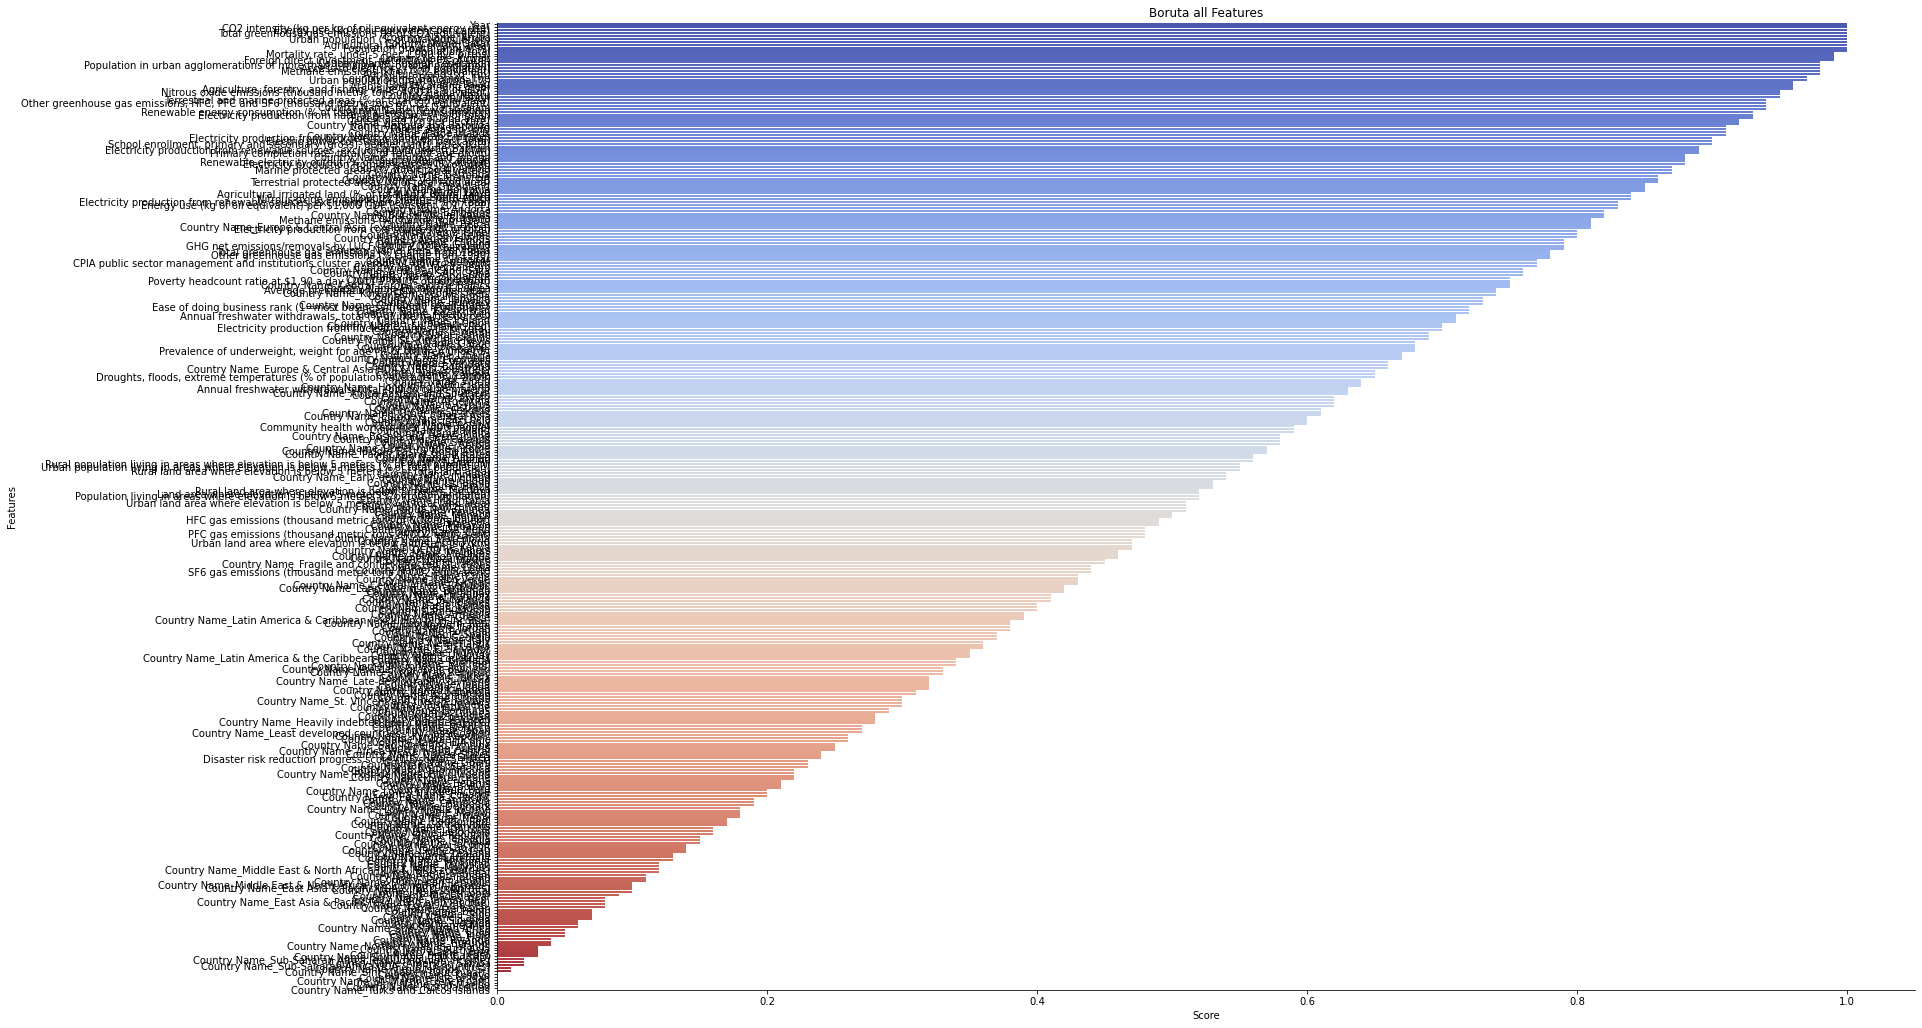

In [16]:
sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[:], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta all Features")

In [17]:
boruta_score.head(11)['Features'].values

array(['Year', 'CO2 intensity (kg per kg of oil equivalent energy use)',
       'Energy use (kg of oil equivalent per capita)',
       'Total greenhouse gas emissions (kt of CO2 equivalent)',
       'Country Name_Aruba', 'Urban population (% of total population)',
       'Country Name_Qatar', 'Agricultural land (% of land area)',
       'Population growth (annual %)', 'Population, total',
       'Mortality rate, under-5 (per 1,000 live births)'], dtype=object)

In [18]:
cols_to_keep = np.delete(boruta_score.head(11)['Features'].values, [4,6])
#Remove Cols that should not be in final dataset
df_final = df_original[cols_to_keep]
df_final.head()

,Year,CO2 intensity (kg per kg of oil equivalent energy use),Energy use (kg of oil equivalent per capita),Total greenhouse gas emissions (kt of CO2 equivalent),Urban population (% of total population),Agricultural land (% of land area),Population growth (annual %),"Population, total","Mortality rate, under-5 (per 1,000 live births)"
0,1960,NaN,NaN,NaN,50.776,NaN,NaN,54208.0,NaN
1,1961,NaN,NaN,NaN,50.761,11.111111,2.236462,55434.0,NaN
2,1962,NaN,NaN,NaN,50.746,11.111111,1.432843,56234.0,NaN
3,1963,NaN,NaN,NaN,50.730,11.111111,0.823502,56699.0,NaN
4,1964,NaN,NaN,NaN,50.715,11.111111,0.580334,57029.0,NaN
